In [1]:
using QuantumCircuits
# using QuantumOptics
using PyPlot
using Random
using Statistics

### Qubit Hilbert space

In [2]:
# Basis
q = SpinBasis(1//2)

# Operators, using convention that |-z> is ground state
σx = sigmax(q)
σy = sigmay(q)
σz = sigmaz(q)
σp = sigmap(q)
σm = sigmam(q)
id = identityoperator(q)

Operator(dim=2x2)
  basis: Spin(1/2)
 1.0+0.0im      ⋅    
     ⋅      1.0+0.0im

# Plain reduced qubit evolution

Work in the rotating frame, so that $\omega_q = 0$ effectively. Thus the Hamiltonian is
$$ H_0 = \frac{\Omega_R}{2} \sigma_x. $$
Measuring the qubit eigenstates $|+z \rangle$ (excited) and $|-z \rangle$ (ground) leads to dissipation operator $J_0 = \sqrt{\Gamma} \sigma_z$ and measurement collapse operator $C_0 = \sqrt{\Gamma \eta}\sigma_z$, where $\Gamma = 1/2\tau$ is the measurement dephasing rate, $\tau$ is the measurement collapse timescale, and $\eta$ is the signal collection efficiency.

### Constants

In [262]:
# initial state
ρ0 = dm(spindown(q))

# Parameters
ΩR  = 2π # Rabi frequency
τ = 3.0# Measurement collapse timescale
Γ = 1/(2τ) # Measurement dephasing rate
T = (0.0, 4τ) # Time duration of simulation
η = 0.3

0.3

### Hamiltonian and dissipation / measurement operators

In [263]:
H0 = ΩR*σy/2
J0 = √Γ*σz
C0 = √(Γ*η)*σz

Operator(dim=2x2)
  basis: Spin(1/2)
 0.223607+0.0im            ⋅    
          ⋅      -0.223607+0.0im

### Utilities

In [264]:
expects = ρ -> collect(real(expect(ρ, s)) for s in [σx,σy,σz,ρ]) # ρ -> [<x>,<y>,<z>,<ρ>]
F(ρ,σ) = norm(tr(sqrt(sqrt(σ.data)*ρ.data*sqrt(σ.data))))^2
average(ρt) = sum(ρt, dims=1)'/size(ρt)[1]

average (generic function with 1 method)

In [265]:
colors[8]

(1.0, 0.4980392156862745, 0.0, 1.0)

In [277]:
# Plotting
function plot_solution(sol; plot_title="Rabi Oscillation", colorscheme="Paired")
    
    tt = sol[1]/τ
    ρt = sol[2]
    
    # Get Bloch components
    evs0 = expects.(ρt);
    xx,yy,zz,ρρ = [map(x -> x[i], evs0) for i in 1:4];
    
    # Plot Bloch components vs. time
    cmap = plt.matplotlib.cm.get_cmap(colorscheme)
    colors=collect(map(x -> cmap(x), 0:11))
    
    p = plot(tt, xx, color=colors[2], label=L"$x$")
    plot(tt, yy, color=colors[4],label=L"$y$")
    ax = gca()
    ax.set_ylim([-1.1,1.1]) 
    plot(tt, zz, color=colors[6], label=L"$z$")
    plot(tt, ρρ, color=colors[8], label=L"Tr $\rho^2$")
    xlabel(L"$t/τ$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    show()
end;


# Plotting
function plot_solutions((sol1,sol2); plot_title="Rabi Oscillation", colorscheme="Paired")
    cmap = plt.matplotlib.cm.get_cmap(colorscheme)
    colors=collect(map(x -> cmap(x), 0:11))
    
    tt1 = sol1[1]/τ
    ρt1 = sol1[2]
    tt2 = sol2[1]/τ
    ρt2 = sol2[2]
    
    # Get Bloch components
    evs1 = expects.(ρt1);
    x1,y1,z1,p1 = [map(x -> x[i], evs1) for i in 1:4];
    evs2 = expects.(ρt2);
    x2,y2,z2,p2 = [map(x -> x[i], evs2) for i in 1:4];
    
    # Plot Bloch components vs. time
    p = plot(tt1, x1, color=colors[2], linewidth=2, label=L"$x_{\eta = 0}$")
    plot(tt1, y1, color=colors[4], linewidth=2, label=L"$y_{\eta = 0}$")
    plot(tt1, z1, color=colors[6], linewidth=2, label=L"$z_{\eta = 0}$")
    plot(tt1, p1, color=colors[8], linewidth=2, label=L"(Tr $\rho^2)_{\eta = 0}$")
    plot(tt2, x2,  color=colors[1], linestyle="dashed", label=L"$x_{avg}$")
    plot(tt2, y2, color=colors[3], linestyle="dashed", label=L"$y_{avg}$")
    plot(tt2, p2, color=colors[7], linewidth=2, linestyle="dashed", label=L"(Tr $\rho^2)_{avg}$")
    ax = gca()
    ax.set_ylim([-1.1,1.1]) 
    
    xlabel(L"$t/τ$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    show()
end;

## Simulate

### Average evolution ($\eta = 0$)

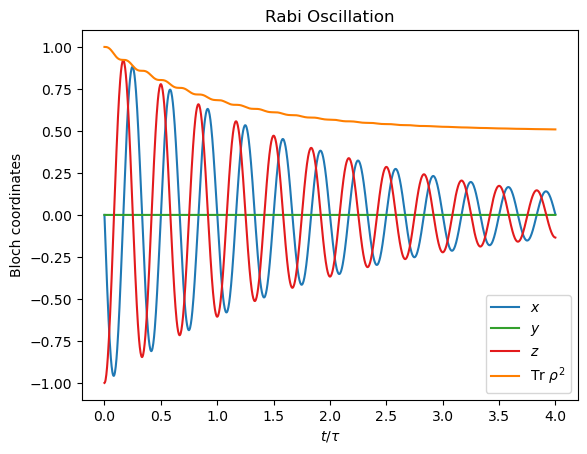

  0.131969 seconds (217.45 k allocations: 22.497 MiB)


In [267]:
dt = 1e-2
sol = @time bayesian((0, 4τ),ρ0, H0, [J0], []; dt=dt);

plot_solution(sol; plot_title="Rabi Oscillation")

### Trajectory evolution ($\eta > 0$)

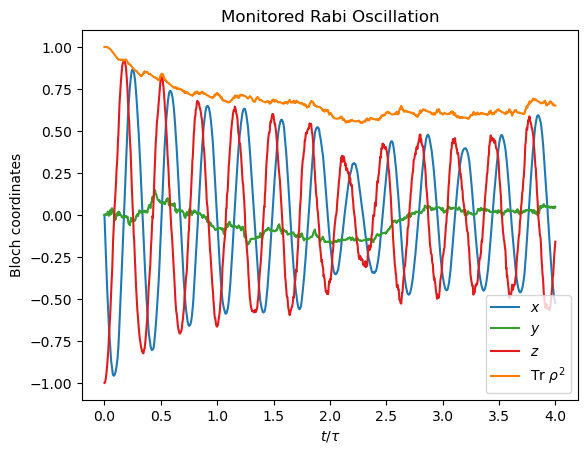

  0.218717 seconds (337.51 k allocations: 32.723 MiB)


In [268]:
Random.seed!(1)
dt = 1e-2
sol1 = @time bayesian((0, 4τ), ρ0, H0, [J0], [C0]; dt=dt);

plot_solution(sol1; plot_title="Monitored Rabi Oscillation")

### Ensemble evolution

In [287]:
btt2, bρt2 = @time ensemble(bayesian, (0,4τ), ρ0, H0, [J0], [C0]; dt=dt, N=50);

  9.457327 seconds (16.87 M allocations: 1.597 GiB, 27.74% gc time)


In [270]:
sol2=(btt2,mean(bρt2));

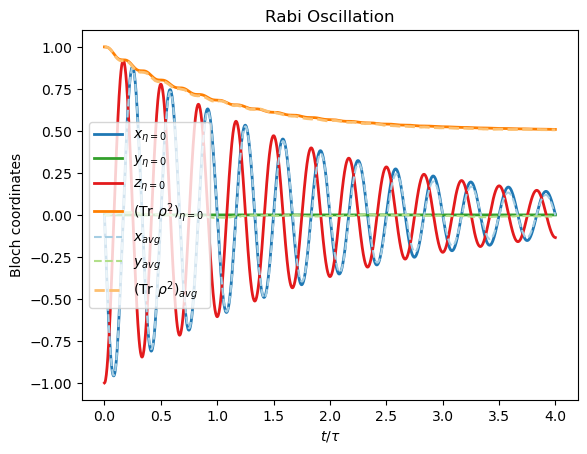

In [278]:
plot_solutions((sol,sol2))

In [279]:
sol_ens = (btt2, bρt2);

In [280]:
colorscheme = "Paired"
cmap = plt.matplotlib.cm.get_cmap(colorscheme)
colors=collect(map(x -> cmap(x), 0:11))

tt1 = sol_ens[1]/τ
evs = collect(map(ρs -> expects.(ρs), sol_ens[2]));

In [281]:
evs[1];

In [284]:
function plot_evals((tt1, evals); α=0.1, linewidth=1, labels=false)
    xxs,yys,zzs,ρρs = [map(x -> x[i], evals) for i in 1:4];
    if labels
        plot(tt1, xxs, color=colors[2], alpha=α, linewidth=linewidth, label=L"$x$")
        plot(tt1, yys, color=colors[4], alpha=α, linewidth=linewidth, label=L"$y$")
        plot(tt1, zzs, color=colors[6], alpha=α, linewidth=linewidth, label=L"$z$")
        plot(tt1, ρρs, color=colors[8], alpha=α, linewidth=linewidth, label=L"Tr $ρ^2$")
    else
        plot(tt1, xxs, color=colors[2], alpha=α, linewidth=linewidth)
        plot(tt1, yys, color=colors[4], alpha=α, linewidth=linewidth)
        plot(tt1, zzs, color=colors[6], alpha=α, linewidth=linewidth)
        plot(tt1, ρρs, color=colors[8], alpha=α, linewidth=linewidth)
        
    end

end

plot_evals (generic function with 1 method)

In [285]:
function plot_ensemble(sol_ens; α=0.1, linewidth=1, labels=false, average=false)
    tt1 = sol_ens[1]/τ
    evs = collect(map(ρs -> expects.(ρs), sol_ens[2]));

    for i in 1:50
        plot_evals((tt1, evs[i]); α=α)
    end

    if average
        plot_evals((tt1, mean(evs)), α=1, linewidth=1.5, labels=true)
        title_string = "Trajectories w/ ensemble average"
    else
        plot_evals((tt1, evs[1]), α=1, linewidth=1.5, labels=true)
        title_string = "Trajectories"
    end
    
    ax = gca()
    ax.set_ylim([-1.1,1.1]) 
    legend()

    xlabel(L"$t/τ$")
    ylabel("Bloch coordinates")
    title(title_string)
end

plot_ensemble (generic function with 1 method)

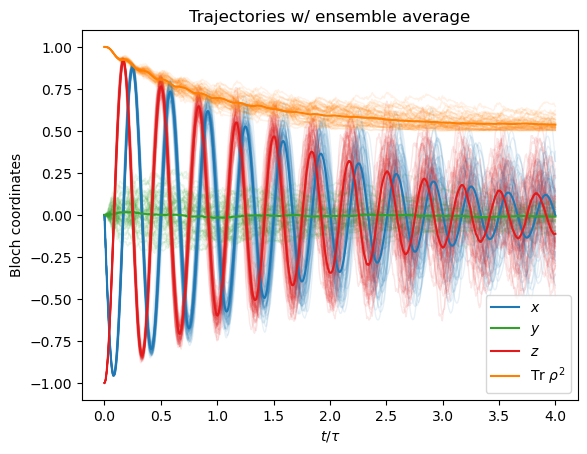

PyObject Text(0.5, 1.0, 'Trajectories w/ ensemble average')

In [286]:
plot_ensemble(sol_ens; average=true)

In [190]:
xxs,yys,zzs = [map(x -> x[i], evs[1]) for i in 1:3];

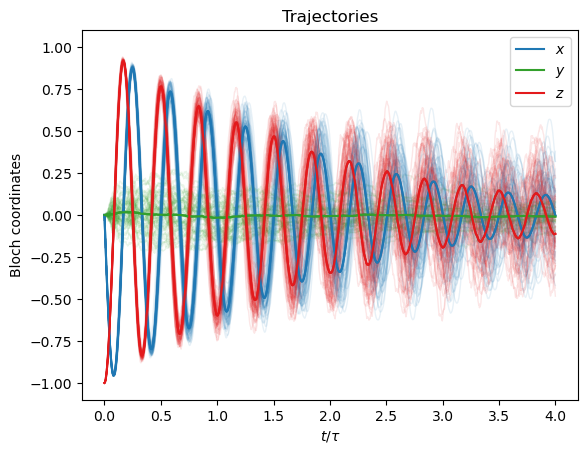

PyObject Text(0.5, 1.0, 'Trajectories')

In [193]:
α = 0.1

p = plot(tt1, xxs, color=colors[2], label=L"$x$")
plot(tt1, yys, color=colors[4], label=L"$y$")
ax = gca()
ax.set_ylim([-1.1,1.1]) 
plot(tt1, zzs, color=colors[6], label=L"$z$")
legend()

for i in 1:50
    plot_evals(evs[i]; α=α)
end

plot(tt1, xxs, color=colors[2])
plot(tt1, yys, color=colors[4])
plot(tt1, zzs, color=colors[6])

xlabel(L"$t/τ$")
ylabel("Bloch coordinates")
title("Trajectories")

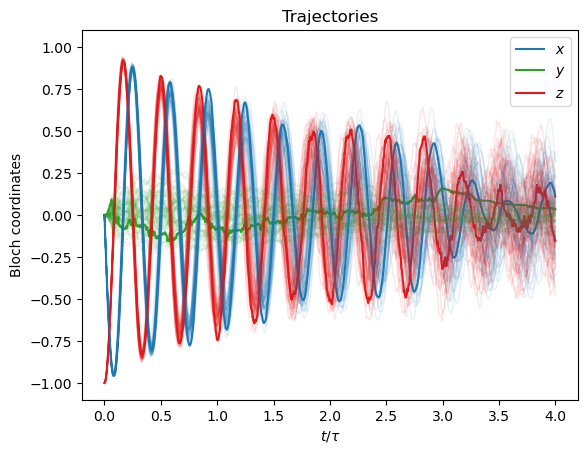

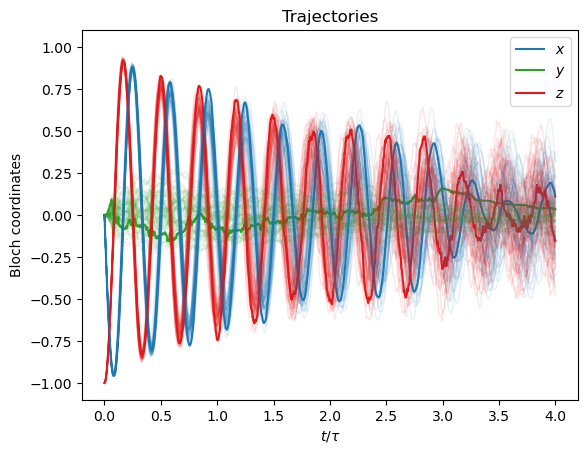

In [201]:
α = 0.1

plot_evals(evs[1], α=1, linewidth=1.5, labels=true)
# plot(tt1, xxs, color=colors[2], alpha=1)
# plot(tt1, yys, color=colors[4], alpha=1)
ax = gca()
ax.set_ylim([-1.1,1.1]) 
# plot(tt1, zzs, color=colors[6], alpha=1)

for i in 2:50
    plot_evals(evs[i]; α=α)
end

evs2 = expects.(sol2[2])
xxs,yys,zzs = [map(x -> x[i], evs2) for i in 1:3];

# plot(tt1, xxs, color=colors[2], label=L"$x$",linewidth=2, linestyle="dashed")
# plot(tt1, yys, color=colors[4], label=L"$y$", linewidth=2, linestyle="dashed")
# plot(tt1, zzs, color=colors[6],  label=L"$z$", linewidth=2, linestyle="dashed")
# legend()

xlabel(L"$t/τ$")
ylabel("Bloch coordinates")
title("Trajectories")
gcf()

In [ ]:

# Get Bloch components
evs1 = expects.(ρt1);
x1,y1,z1 = [map(x -> x[i], evs1) for i in 1:3];
evs2 = expects.(ρt2);
x2,y2,z2 = [map(x -> x[i], evs2) for i in 1:3];

# Plot Bloch components vs. time
p = plot(tt1, x1, color=colors[2], label=L"$x$")
plot(tt2, x2,  color=colors[1], linestyle="dashed", label=L"$x$")
plot(tt1, y1, color=colors[4], label=L"$y$")
plot(tt2, y2, color=colors[3], linestyle="dashed", label=L"$y$")
ax = gca()
ax.set_ylim([-1.1,1.1]) 
plot(tt1, z1, color=colors[6], label=L"$z$")
plot(tt2, z2, color=colors[5], linestyle="dashed", label=L"$z$")
xlabel(L"$t/τ$")
ylabel("Bloch coordinates")
title(plot_title)
legend()
gcf()

## Comparing simulation methods

## Bayesian Test

In [52]:
# Parameters
n = 150 # ensemble size
Ω  = 2π # Rabi frequency
τ = 3.0 # Measurement collapse timescale
Γ = 1/(2τ) # Measurement dephasing rate
T = (0.0, 6τ) # Time duration of simulation
η = 0.3

# Basis
q = SpinBasis(1//2)

# Operators
σx = sigmax(q)
σy = sigmay(q)
σz = sigmaz(q)
id = identityoperator(q)

# Helper
expects = ρ -> collect(real(expect(ρ, s)) for s in [σx,σy,σz]) # ρ -> [<x>,<y>,<z>]
ispositive = ρ -> begin
  mineig = eigmin(real(ρ))
  if mineig > 0 || abs(mineig) < 1e-10
      return true
  else 
      return false
  end
end

F(ρ,σ) = norm(tr(sqrt(sqrt(σ.data)*ρ.data*sqrt(σ.data))))^2
average(ρt) = sum(ρt)'/size(ρt)[1]

average (generic function with 1 method)

In [20]:
Random.seed!(1)

dt = 1e-4
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2

tt1, ρt1 = @time rouchon(T, ρ0, H0, [J0], [C0]; dt=dt)
tt1, ρct1 = @time rouchon(T, u, H0, [J0], [C0]; dt=dt);

  1.488604 seconds (26.59 M allocations: 1.966 GiB, 23.62% gc time)
  1.560597 seconds (26.46 M allocations: 1.958 GiB, 34.67% gc time)


In [21]:
Random.seed!(1)

dt = 1e-3
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2

tt2, ρt2 = @time rouchon(T, ρ0, H0, [J0], [C0]; dt=dt)
tt2, ρct2 = @time rouchon(T, u, H0, [J0], [C0]; dt=dt);

  0.150452 seconds (2.64 M allocations: 200.701 MiB, 27.90% gc time)
  0.140953 seconds (2.64 M allocations: 200.701 MiB, 27.49% gc time)


In [22]:
Random.seed!(1)

dt = 1e-2
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2

tt3, ρt3 = @time rouchon(T, ρ0, H0, [J0], [C0]; dt=dt)
tt3, ρct3 = @time rouchon(T, u, H0, [J0], [C0]; dt=dt);

  0.017213 seconds (262.24 k allocations: 20.029 MiB)
  0.014940 seconds (262.24 k allocations: 20.029 MiB)


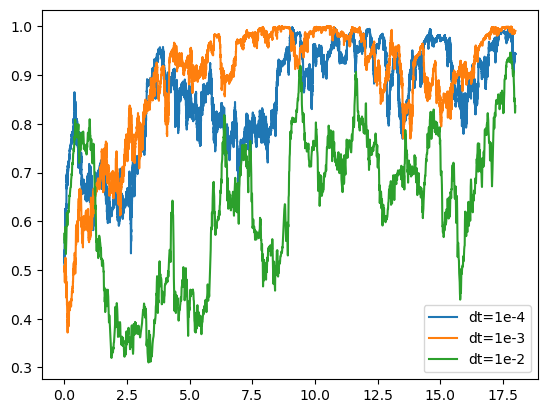

PyObject <matplotlib.legend.Legend object at 0x7f96031d2670>

In [23]:
plt.plot(tt1, F.(ρt1, ρct1), label="dt=1e-4")
plt.plot(tt2, F.(ρt2, ρct2), label="dt=1e-3")
plt.plot(tt3, F.(ρt3, ρct3), label="dt=1e-2")
plt.legend()

# Ensemble Average Fidelity Comparisons

In [24]:
@everywhere begin
dt = 1e-3
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2
end

tt1, ρt1 = @time ensemble(rouchon, T, ρ0, H0, [J0], [C0]; dt=dt, N=500)
tt1, ρct1 = @time ensemble(rouchon, T, u, H0, [J0], [C0]; dt=dt, N=500);

 71.093408 seconds (1.33 G allocations: 98.230 GiB, 24.30% gc time, 0.97% compilation time)
178.058164 seconds (1.32 G allocations: 97.999 GiB, 69.56% gc time)


In [25]:
@everywhere begin
dt = 1e-2
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2
end

tt3, ρt3 = @time ensemble(rouchon, T, ρ0, H0, [J0], [C0]; dt=dt, N=500)
tt3, ρct3 = @time ensemble(rouchon, T, u, H0, [J0], [C0]; dt=dt, N=500);

 22.211674 seconds (131.12 M allocations: 9.780 GiB, 75.11% gc time)
 19.305805 seconds (131.12 M allocations: 9.780 GiB, 72.31% gc time)


In [26]:
@everywhere begin
dt = 1e-2
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2
end

btt2, bρt2 = @time ensemble(bayesian, T, ρ0, H0, [J0], [C0]; dt=dt, N=500)
btt2, bρct2 = @time ensemble(bayesian, T, u, H0, [J0], [C0]; dt=dt, N=500);

 51.081890 seconds (295.25 M allocations: 27.283 GiB, 38.71% gc time, 2.73% compilation time)
 52.787744 seconds (294.51 M allocations: 27.239 GiB, 43.11% gc time)


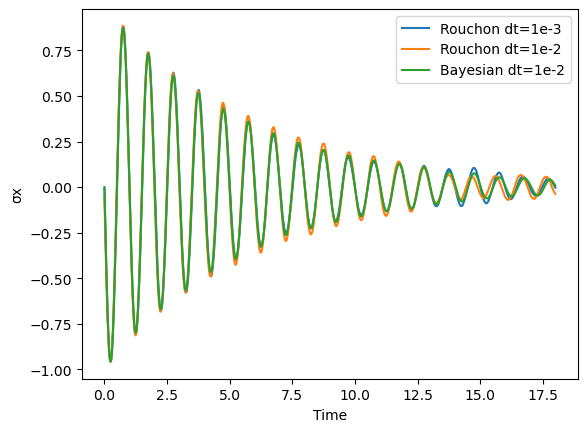

PyObject <matplotlib.legend.Legend object at 0x7f91dfc57d00>

In [125]:
plt.plot(tt1, map(x -> x[1], expects.(average(ρt1)[1,:])), label="Rouchon dt=1e-3")
plt.plot(btt2, map(x -> x[1], expects.(average(ρt3)[1,:])), label="Rouchon dt=1e-2")
plt.plot(btt2, map(x -> x[1], expects.(average(bρt2)[1,:])), label="Bayesian dt=1e-2")
plt.xlabel("Time")
plt.ylabel("σx")
plt.legend()

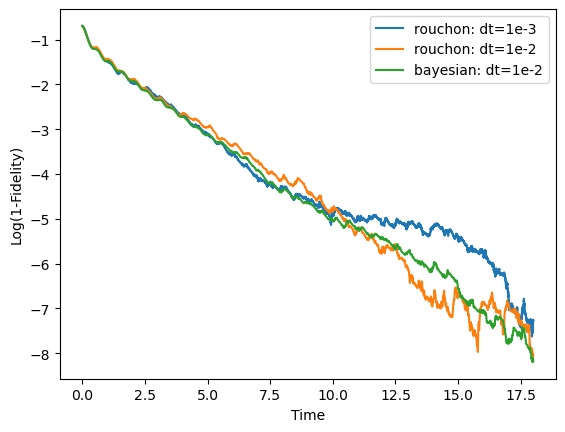

PyObject <matplotlib.legend.Legend object at 0x7f91dfa8edf0>

In [124]:
plt.plot(tt1, log.(1 .- F.(average(ρt1), average(ρct1)))[1,:], label="rouchon: dt=1e-3")
plt.plot(tt3, log.(1 .- F.(average(ρt3), average(ρct3)))[1,:], label="rouchon: dt=1e-2")
# plt.plot(tt1, log.(1 .- F.(average(ρt1), average(ρct1[1]))), label="rouchon: dt=1e-3")
plt.plot(btt2, log.(1 .- F.(average(bρt2), average(bρct2)))[1,:], label="bayesian: dt=1e-2")
# plt.plot(btt1, log.(1 .- F.(average(bρt1), average(bρct1))), label="bayesian: dt=1e-3")
plt.xlabel("Time")
plt.ylabel("Log(1-Fidelity)")
plt.legend()

# Coarse Graining

In [126]:
function coarsegrain(fine=[]; n=2)
    coarse = []
    for i in 1:length(fine)
        if i < n
            push!(coarse, mean(fine[1:i]))
        else
            push!(coarse, mean(fine[i-(n-1):i]))
        end
    end
    coarse
end

function select(a=[]; n=2)
    a[filter(x -> x%n==1, eachindex(a))]
end

select (generic function with 2 methods)

## No Unitary Evolution

In absence of unitary evolution, Bayesian update should be $dt$ invariant.

In [210]:
dt = 1e-2
ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

η = 1
J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = 0σz

T = (0,45)

scale=10

Random.seed!(1)
tt, ρt, dy = @time bayesian(T, ρ0, H0, [J0], [C0]; dt=dt/scale);
tt, ρtu, dyu = @time bayesian(T, u, H0, [J0], [C0]; dt=dt/scale, dy=dy);

ro = coarsegrain(dy[1]; n=scale)
ros = select(ro; n=scale)
tt2, ρt2, dy2 = @time bayesian(T, ρ0, H0, [J0], [C0]; dt=dt, dy=[ros]);
tt2, ρtu2, dyu2 = @time bayesian(T, u, H0, [J0], [C0]; dt=dt, dy=dy2);

  1.474474 seconds (14.54 M allocations: 1.370 GiB, 29.66% gc time)
 11.799277 seconds (12.29 M allocations: 16.322 GiB, 23.99% gc time)
  0.244103 seconds (1.24 M allocations: 281.567 MiB, 24.61% gc time)
  0.233567 seconds (1.23 M allocations: 280.880 MiB, 27.83% gc time)


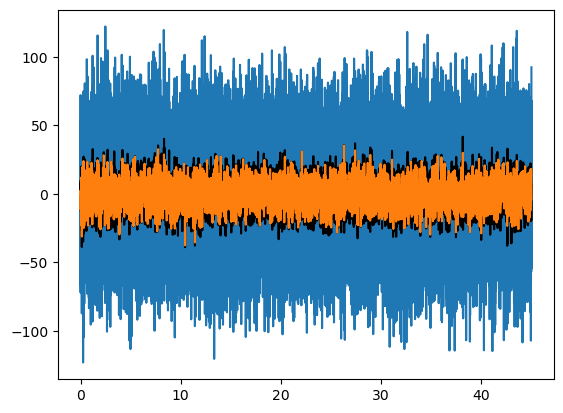

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f91f76ee4c0>

In [211]:
plt.plot(tt, dy[1])
plt.plot(tt, coarsegrain(dy[1], n=scale), "black")
plt.plot(select(tt, n=scale), select(coarsegrain(dy[1], n=scale), n=scale))

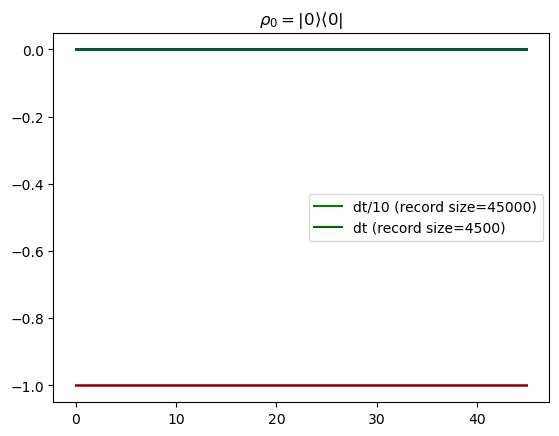

PyObject <matplotlib.legend.Legend object at 0x7f95d3b33d00>

In [212]:
evs = expects.(ρt)
evs = [evs[n][ax] for n in 1:length(tt), ax in 1:3]
plt.plot(tt, evs[:,3], "red")
plt.plot(tt, evs[:,2], "blue")
plt.plot(tt, evs[:,1], "green", label="dt/$scale (record size=$(length(tt)-1))")

evs2 = expects.(ρt2)
evs2 = [evs2[n][ax] for n in 1:length(tt2), ax in 1:3]
plt.plot(tt2, evs2[:,3], "darkred")
plt.plot(tt2, evs2[:,2], "darkblue")
plt.plot(tt2, evs2[:,1], "darkgreen", label="dt (record size=$(length(tt2)-1))")

plt.title(L"ρ_0 = |0\rightangle \leftangle 0|")
plt.legend()

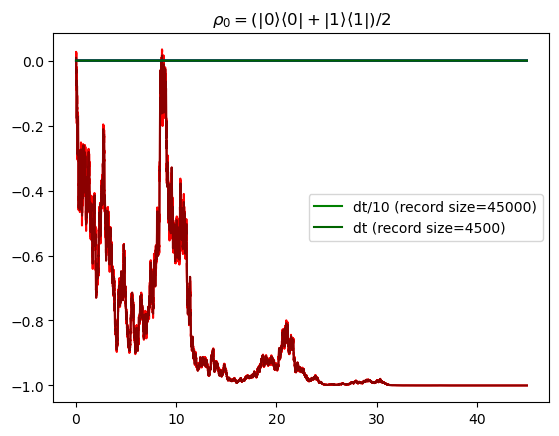

PyObject <matplotlib.legend.Legend object at 0x7f961ec1bb50>

In [213]:
evsu = expects.(ρtu)
evsu = [evsu[n][ax] for n in 1:length(tt), ax in 1:3]
plt.plot(tt, evsu[:,3], "red")
plt.plot(tt, evsu[:,2], "blue")
plt.plot(tt, evsu[:,1], "green", label="dt/$scale (record size=$(length(tt)-1))")

evsu2 = expects.(ρtu2)
evsu2 = [evsu2[n][ax] for n in 1:length(tt2), ax in 1:3]
plt.plot(tt2, evsu2[:,3], "darkred")
plt.plot(tt2, evsu2[:,2], "darkblue")
plt.plot(tt2, evsu2[:,1], "darkgreen", label="dt (record size=$(length(tt2)-1))")

plt.title(L"ρ_0 = (|0\rightangle \leftangle 0| + |1\rightangle \leftangle 1|)/2")
plt.legend()

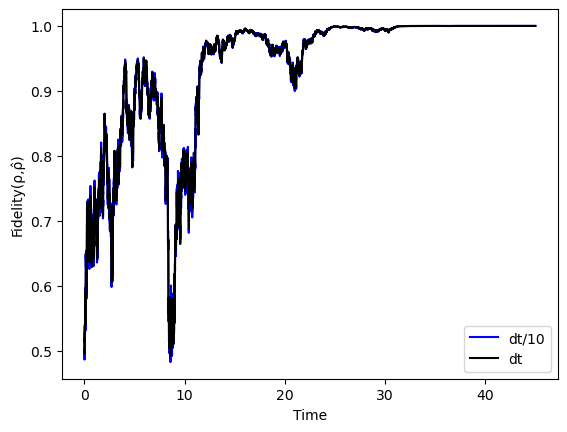

PyObject <matplotlib.legend.Legend object at 0x7f961a25b7c0>

In [214]:
plt.plot(tt, F.(ρt, ρtu), "blue", label="dt/$scale")
plt.plot(tt2, F.(ρt2, ρtu2), "black", label="dt")
plt.xlabel("Time")
plt.ylabel("Fidelity(ρ,ρ̂)")
plt.legend()

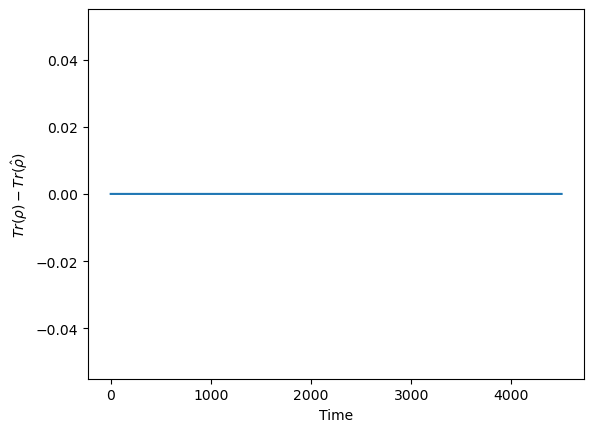

PyObject Text(30.236111111111114, 0.5, '$Tr(\\rho)-Tr(\\hat\\rho)$')

In [215]:
plt.plot(round.(tr.(select(ρt; n=scale) .- ρt2), digits=8))
plt.xlabel("Time")
plt.ylabel(L"Tr(\rho)-Tr(\hat\rho)")

## Unitary Evolution

In [144]:
dt = 1e-2
ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2

T = (0, 6τ)

scale=100

Random.seed!(1)
tt, ρt, dy = @time bayesian(T, ρ0, H, [J0], [C0]; dt=dt/scale);
tt, ρtu, dyu = @time bayesian(T, u, H, [J0], [C0]; dt=dt/scale, dy=dy);

ro = coarsegrain(dy[1]; n=scale)
ros = select(ro; n=scale)
tt2, ρt2, dy2 = @time bayesian(T, ρ0, H, [J0], [C0]; dt=dt, dy=[ros]);
tt2, ρtu2, dyu2 = @time bayesian(T, u, H, [J0], [C0]; dt=dt, dy=dy2);

 11.187477 seconds (61.56 M allocations: 5.431 GiB, 44.07% gc time)
182.996617 seconds (52.82 M allocations: 246.306 GiB, 25.57% gc time, 0.07% compilation time)
  0.226617 seconds (789.38 k allocations: 92.718 MiB, 9.57% gc time, 59.89% compilation time)
  0.083436 seconds (525.18 k allocations: 75.084 MiB, 21.99% gc time)


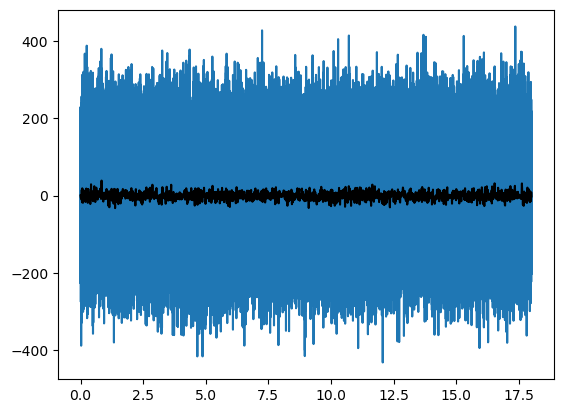

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f91caaad160>

In [145]:
plt.plot(tt, dy[1])
plt.plot(tt2, dy2[1], "black")

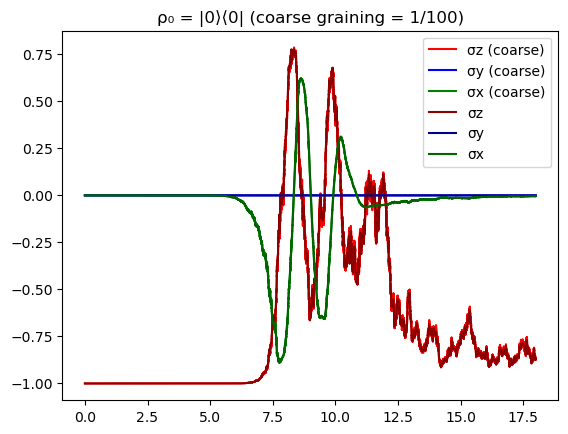

PyObject <matplotlib.legend.Legend object at 0x7f91dfa27850>

In [163]:
evs = expects.(ρt)
evs = [evs[n][ax] for n in 1:length(tt), ax in 1:3]
plt.plot(tt, evs[:,3], "red", label="σz (coarse)")
plt.plot(tt, evs[:,2], "blue", label="σy (coarse)")
plt.plot(tt, evs[:,1], "green", label="σx (coarse)")

evs2 = expects.(ρt2)
evs2 = [evs2[n][ax] for n in 1:length(tt2), ax in 1:3]
plt.plot(tt2, evs2[:,3], "darkred", label="σz")
plt.plot(tt2, evs2[:,2], "darkblue", label="σy")
plt.plot(tt2, evs2[:,1], "darkgreen", label="σx")

plt.title("ρ₀ = |0⟩⟨0| (coarse graining = 1/$scale)")
plt.legend()

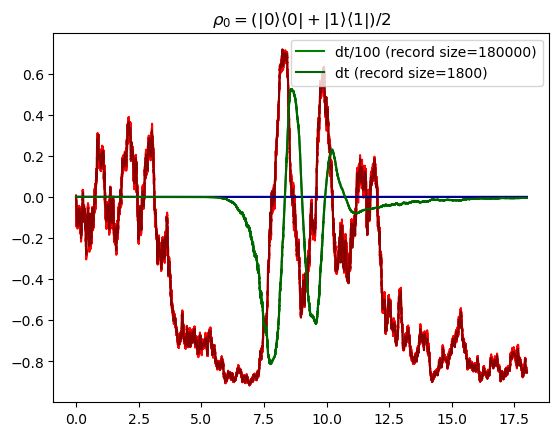

PyObject <matplotlib.legend.Legend object at 0x7f919a7d1fa0>

In [156]:
evsu = expects.(ρtu)
evsu = [evsu[n][ax] for n in 1:length(tt), ax in 1:3]
plt.plot(tt, evsu[:,3], "red")
plt.plot(tt, evsu[:,2], "blue")
plt.plot(tt, evsu[:,1], "green", label="dt/$scale (record size=$(length(tt)-1))")

evsu2 = expects.(ρtu2)
evsu2 = [evsu2[n][ax] for n in 1:length(tt2), ax in 1:3]
plt.plot(tt2, evsu2[:,3], "darkred")
plt.plot(tt2, evsu2[:,2], "darkblue")
plt.plot(tt2, evsu2[:,1], "darkgreen", label="dt (record size=$(length(tt2)-1))")

plt.title(L"ρ_0 = (|0\rightangle \leftangle 0| + |1\rightangle \leftangle 1|)/2")
plt.legend()

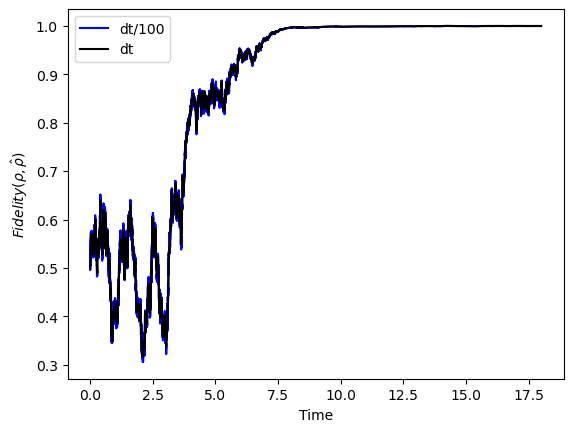

PyObject <matplotlib.legend.Legend object at 0x7f91d2989700>

In [148]:
plt.plot(tt, F.(ρt, ρtu), "blue", label="dt/$scale")
plt.plot(tt2, F.(ρt2, ρtu2), "black", label="dt")
plt.xlabel("Time")
plt.ylabel(L"Fidelity(\rho,\hat\rho)")
plt.legend()

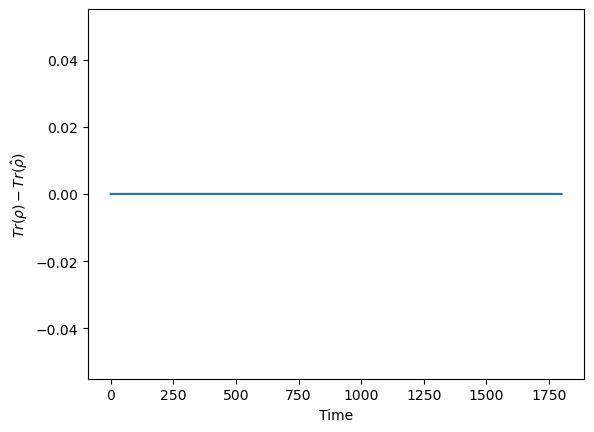

PyObject Text(30.236111111111114, 0.5, '$Tr(\\rho)-Tr(\\hat\\rho)$')

In [149]:
plt.plot(round.(tr.(select(ρt; n=scale) .- ρt2), digits=8))
plt.xlabel("Time")
plt.ylabel(L"Tr(\rho)-Tr(\hat\rho)")

# Reduced Qubit Rabi Correction

In [324]:
# using HDF5

In [ ]:
# (t, ρ) -> σ*(randn() + im*randn())/√dt + expect(ρ, m(t))

In [322]:
# Undriven
ρ0 = dm(spinup(q))
σm = (σx + im*σy)/2

T = (0, 40*2e-7)
dt = 1e-9

κ = 2π*(1.56e6)
χ = 2π*(-0.47e6)
η = 0.17
γ1 = 1/(160e-6)
γϕ = 1/(16e-6)
ΩR = 0.3κ
θtilt = atan(2ΩR/κ)
ηz = cos(θtilt)^2
n̄ = 0.22
Γₘ = 8ηz*χ^2*n̄/κ / (1 + ηz*(2χ/κ)^2)
ẑeff = cos(θtilt)*σz - sin(θtilt)*σy

J = [sqrt((1-η)*Γₘ/2)*ẑeff, sqrt(γ1)σm, sqrt(γϕ/2)σz]
C = [ẑeff/(η*Γₘ)]
H0 = (ΩR/2) * (cos(θtilt)*σx + sin(θtilt)*σy)

# Random.seed!(1)
tt, ρt, dy = @time bayesian(T, ρ0, H0, J, C; dt=dt);
dy[1]

  0.479606 seconds (3.20 M allocations: 303.233 MiB, 21.12% gc time)


8000-element view(::Matrix{Float64}, 1, :) with eltype Float64:
      0.0
 -25147.485791893585
  13579.045085201747
 -41111.923355063256
  46945.746876858364
  47335.14632128935
  52746.39898444461
 -14453.232707462528
 -27752.94247863751
  32841.5201518243
   3496.5030480665523
 -11810.054699993967
 -35244.28568189806
      ⋮
  -8506.400386209023
  52837.73000132421
  11397.25858961875
 -13317.26838777514
 -13435.427235098128
   -628.5754018676462
   1347.8065351685664
  30047.67432719368
  17537.0916482934
   1456.160822751955
  12233.34861962496
  34972.607899346716

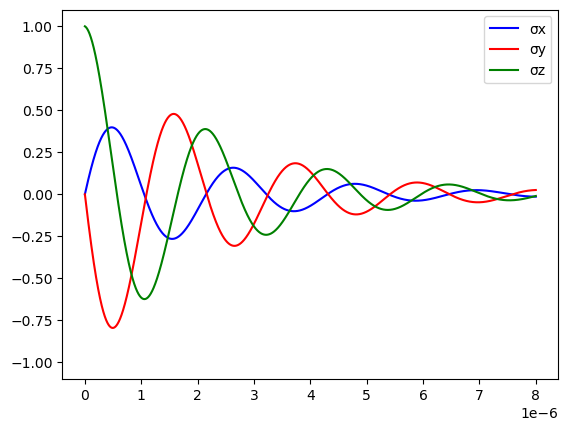

PyObject <matplotlib.legend.Legend object at 0x7f935b04a8b0>

In [323]:
eρt = expects.(ρt)
plt.plot(tt, map(x -> x[1], eρt), color="blue", label="σx")
plt.plot(tt, map(x -> x[2], eρt), color="red", label="σy")
plt.plot(tt, map(x -> x[3], eρt), color="green", label="σz")
plt.ylim(-1.1,1.1)
plt.legend()